# Conformal Experiment: Increase Confidence Softmax

In [52]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
# === Softmax ===
n_classes = 10
random_expert_idx = 0
probs_softmax = []
confs = []
exps = []
true = []
path = "softmax_increase_confidence/"
n_experts = 4
p_experts = [0.2, 0.4, 0.6, 0.8, 0.95]
for p in p_experts:
    model_name = '_' + str(p) + '_confidence'
    with open(path + 'confidence_multiple_experts' + model_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    print(c.shape)
    # DANI Correction ===
    c = c.softmax(dim=1)
    probs_softmax.append(c)
    # DANI Correction ===

    temp = 0
    for i in range(n_experts):
        temp += c[:, (n_classes + n_experts) - (i + 1)]
    prob = c / (1.0 - temp).unsqueeze(-1)
    confs.append(prob)


torch.Size([9216, 14])
torch.Size([9216, 14])
torch.Size([9216, 14])
torch.Size([9216, 14])
torch.Size([9216, 14])


### Use c, not conf, because we do not apply temperature scaling

In [3]:
# 1 expert rando, 3 with prob 0.8 correct
probs = probs_softmax[-1]
experts = exps[-1]
# experts = experts[::-1]  # reverse order!
y_true = true[-1]

In [4]:
probs[:5,10:]

tensor([[0.0229, 0.2398, 0.2286, 0.2388],
        [0.0531, 0.1710, 0.1525, 0.1687],
        [0.0401, 0.1389, 0.1312, 0.1402],
        [0.0262, 0.2352, 0.2380, 0.2364],
        [0.0520, 0.1344, 0.1481, 0.1544]])

In [5]:
np.array(experts)

array([[6, 6, 0, ..., 7, 5, 3],
       [3, 5, 3, ..., 4, 9, 5],
       [3, 8, 2, ..., 5, 0, 5],
       [3, 2, 8, ..., 2, 5, 5]])

In [6]:
y_true[:5]

[3, 8, 8, 0, 6]

In [7]:
n_val = int(0.8 * len(y_true))
n_test = len(y_true) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

N val:7372
N test:1844


In [8]:
probs

tensor([[1.1831e-04, 2.8523e-04, 7.9228e-04,  ..., 2.3978e-01, 2.2855e-01,
         2.3876e-01],
        [2.9309e-04, 5.0115e-04, 3.2451e-05,  ..., 1.7100e-01, 1.5253e-01,
         1.6869e-01],
        [2.1325e-03, 6.9851e-03, 2.8766e-04,  ..., 1.3888e-01, 1.3124e-01,
         1.4023e-01],
        ...,
        [1.0121e-03, 7.4800e-05, 3.5026e-01,  ..., 2.0158e-01, 2.0653e-01,
         2.0776e-01],
        [7.1184e-03, 3.3438e-03, 4.9556e-03,  ..., 2.0613e-01, 2.0641e-01,
         2.1030e-01],
        [2.6729e-07, 1.6294e-07, 4.7181e-06,  ..., 2.4467e-01, 2.3259e-01,
         2.3115e-01]])

# Validation

In [10]:
## 2. get Q_hat

n_classes_exp = n_classes + n_experts
probs_val = probs[:n_val, 10:]

# experts_val = experts[::-1]  # IMPORTANT! swap to match prob ordering
experts_val = experts
experts_val = [exp[:n_val] for exp in experts_val]

y_true_val = y_true[:n_val]

# === Only on deferred samples
_, predicted = torch.max(probs[:n_val].data, 1)
r = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_val = probs_val[r]
experts_val = [np.array(exp)[r] for exp in experts_val]
y_true_val = np.array(y_true_val)[r]

# Model expert probs ===
# Sort J model outputs for experts
probs_experts = probs[:n_val, 10:]
probs_experts = probs_experts[r]
sort, pi = probs_experts.sort(dim=1, descending=True)

# Correctness experts ===
# Check if experts are correct 
correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
# idx for correct experts: [[0,1,2], [1,2], [], ...]
correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

# obtain the last expert to be retrieved. If empty, then add all values.
# indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

# obtain real expert index back, e.g. [2,1,-1,...]
pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]


# =========
n_val = n_val
alpha = 0.1
scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
qhat = torch.quantile(scores, np.ceil((r.sum() + 1) * (1 - alpha)) / r.sum(), interpolation="higher")

qhat

tensor(0.7653)

In [11]:
probs_val

tensor([[0.0229, 0.2398, 0.2286, 0.2388],
        [0.0338, 0.2394, 0.2383, 0.2411],
        [0.0278, 0.2239, 0.2299, 0.2323],
        ...,
        [0.0278, 0.2555, 0.2535, 0.2674],
        [0.0292, 0.2298, 0.2358, 0.2510],
        [0.0301, 0.2586, 0.2611, 0.2581]])

In [12]:
probs[:,10:]

tensor([[0.0229, 0.2398, 0.2286, 0.2388],
        [0.0531, 0.1710, 0.1525, 0.1687],
        [0.0401, 0.1389, 0.1312, 0.1402],
        ...,
        [0.0255, 0.2016, 0.2065, 0.2078],
        [0.0438, 0.2061, 0.2064, 0.2103],
        [0.0207, 0.2447, 0.2326, 0.2311]])

In [13]:
sort.cumsum(dim=1).gather(1, pi.argsort(1))

tensor([[0.7300, 0.2398, 0.7071, 0.4785],
        [0.7527, 0.4806, 0.7188, 0.2411],
        [0.7139, 0.6861, 0.4622, 0.2323],
        ...,
        [0.8041, 0.5229, 0.7763, 0.2674],
        [0.7458, 0.7166, 0.4868, 0.2510],
        [0.8079, 0.5197, 0.2611, 0.7778]])

In [14]:
y_true_val

array([3, 1, 6, ..., 0, 2, 3])

In [15]:
np.array(experts_val)

array([[6, 6, 4, ..., 0, 9, 8],
       [3, 1, 6, ..., 0, 2, 3],
       [3, 1, 9, ..., 0, 2, 3],
       [3, 1, 8, ..., 0, 2, 3]])

# Test

In [16]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:, n_classes:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [17]:
probs_test.sum(1)

tensor([0.6833, 0.7459, 0.7966,  ..., 0.6414, 0.6666, 0.7291])

In [18]:
# === Only on deferred samples
_, predicted = torch.max(probs[n_val:].data, 1)
r_test = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_test = probs_test[r_test]
experts_test = [np.array(exp)[r_test] for exp in experts_test]
y_true_test = np.array(y_true_test)[r_test]

# Sort J model outputs for experts. sorted probs and sorted indexes
sort_test, pi_test = probs_test.sort(dim=1, descending=True)
# Get last sorted index to be below Q_hat
pi_stop = (sort_test.cumsum(dim=1) <= qhat).sum(axis=1)

# Prediction sets
prediction_sets = [(pi_test[i][:(pi_stop[i])]).numpy() for i in range(pi_stop.shape[0])]  # not allow empty sets
prediction_sets[:5]

[array([3, 2, 1, 0]),
 array([1, 3]),
 array([2, 3, 1, 0]),
 array([2, 1, 3, 0]),
 array([3, 1, 2, 0])]

In [19]:
r.sum()

tensor(2632)

<AxesSubplot:ylabel='Count'>

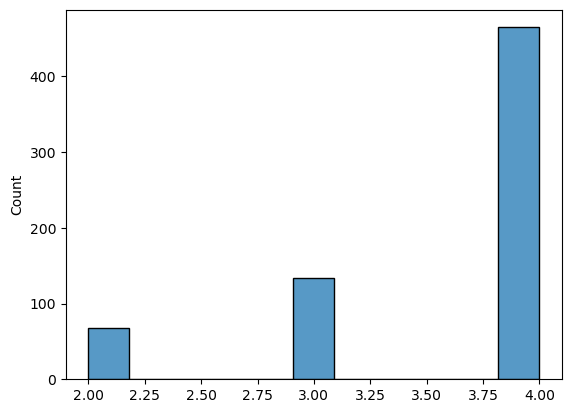

In [20]:
a = np.array([len(prediction_sets_i) for prediction_sets_i in prediction_sets])
import seaborn as sns

sns.histplot(a)

In [21]:
np.array(experts_test)[:,:5]

array([[1, 8, 1, 0, 0],
       [0, 3, 2, 3, 4],
       [0, 3, 2, 3, 4],
       [0, 3, 2, 2, 4]])

# Accuracy

### Accuracy w/o Conformal on deferred samples

In [22]:
correct = 0
correct_sys = 0
exp = 0
exp_total = 0
total = 0
real_total = 0
alone_correct = 0
#  === Individual Expert Accuracies === #
expert_correct_dic = {k: 0 for k in range(len(experts_test))}
expert_total_dic = {k: 0 for k in range(len(experts_test))}

In [23]:
# 1 expert rando, 3 with prob 0.9 correct
probs = probs_softmax[-1]
experts = exps[-1]
# experts = experts[::-1] 
y_true = true[-1]

In [24]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [25]:
probs.shape

torch.Size([9216, 14])

In [26]:
# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

### w Conformal Prediction

In [27]:
probs.sum(1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [28]:
labels = y_true_test

# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)
for i in range(0, n_test):
    r = (predicted[i].item() >= n_classes_exp - len(experts_test))
    alone_correct += (prediction[i] == labels[i]).item()
    if r == 0:
        total += 1
        correct += (predicted[i] == labels[i]).item()
        correct_sys += (predicted[i] == labels[i]).item()
        
    if r == 1:
        # Conformal prediction ===        
        # Sort J model outputs for experts. sorted probs and sorted indexes
        sort_i, pi_i = probs_test[i,n_classes:].sort(descending=True)
        # Get last sorted index to be below Q_hat
        pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()

        # Prediction sets
        prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        
#         print(len(prediction_set_i))
        ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode
        # Conformal prediction ===
        
        # Deferral accuracy: No matter expert ===
        exp += (exp_prediction == labels[i])
        exp_total += 1
        # Individual Expert Accuracy ===
        # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
        # expert_total_dic[deferred_exp] += 1
        #
        correct_sys += (exp_prediction == labels[i])
    real_total += 1
    
#  ===  Coverage  === #    
cov = str(total) + str(" out of") + str(real_total)

#  === Individual Expert Accuracies === #
expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
             in range(len(experts_test))}






In [29]:
exp_prediction

array([5])

In [30]:
sort_i

tensor([0.2103, 0.2064, 0.2061, 0.0438])

In [31]:
print("Cov: {}".format(100 * (total/real_total)))

Cov: 63.82863340563991


In [32]:
expert_accuracies

{'expert_0': 0.0, 'expert_1': 0.0, 'expert_2': 0.0, 'expert_3': 0.0}

In [33]:
100 * exp / (exp_total + 0.0002),

(array([86.2068707]),)

In [34]:
exp_total

667

In [35]:
100 * correct_sys / real_total

array([89.37093275])

### w/o Conformal Prediction

In [36]:
correct = 0
correct_sys = 0
exp = 0
exp_total = 0
total = 0
real_total = 0
alone_correct = 0
#  === Individual Expert Accuracies === #
expert_correct_dic = {k: 0 for k in range(len(experts_test))}
expert_total_dic = {k: 0 for k in range(len(experts_test))}

In [37]:
# 1 expert rando, 3 with prob 0.9 correct
probs = probs_softmax[-1]
experts = exps[-1]
# experts = experts[::-1] 
y_true = true[-1]

In [38]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [39]:
# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

In [40]:
labels = y_true_test

# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)
for i in range(0, n_test):
    r = (predicted[i].item() >= n_classes_exp - len(experts_test))
    alone_correct += (prediction[i] == labels[i]).item()
    if r == 0:
        total += 1
        correct += (predicted[i] == labels[i]).item()
        correct_sys += (predicted[i] == labels[i]).item()
        
    if r == 1:
        deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
        # print("def exp: {}".format(deferred_exp))
        # deferred_exp = ((n_classes - 1) - predicted[i]).item()  # reverse order, as in loss function
        exp_prediction = experts_test[deferred_exp][i]
        # print("exp pred: {}".format(exp_prediction))
        #
        # Deferral accuracy: No matter expert ===
        exp += (exp_prediction == labels[i])
        # print("label: {}".format(labels[i]))

        exp_total += 1
        # Individual Expert Accuracy ===
        expert_correct_dic[deferred_exp] += (exp_prediction == labels[i])
        expert_total_dic[deferred_exp] += 1
        #
        correct_sys += (exp_prediction == labels[i])
    real_total += 1
    
#  ===  Coverage  === #    
cov = str(total) + str(" out of") + str(real_total)

#  === Individual Expert Accuracies === #
expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
             in range(len(experts_test))}






In [41]:
(predicted[i] - n_classes)

tensor(-5)

In [42]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [43]:
# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

In [44]:
labels = y_true_test

# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)
for i in range(0, n_test):
    r = (predicted[i].item() >= n_classes_exp - len(experts_test))
    alone_correct += (prediction[i] == labels[i]).item()
    if r == 0:
        total += 1
        correct += (predicted[i] == labels[i]).item()
        correct_sys += (predicted[i] == labels[i]).item()
        
    if r == 1:
        deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
        # print("def exp: {}".format(deferred_exp))
        # deferred_exp = ((n_classes - 1) - predicted[i]).item()  # reverse order, as in loss function
        exp_prediction = experts_test[deferred_exp][i]
        # print("exp pred: {}".format(exp_prediction))
        #
        # Deferral accuracy: No matter expert ===
        exp += (exp_prediction == labels[i])
        # print("label: {}".format(labels[i]))

        exp_total += 1
        # Individual Expert Accuracy ===
        expert_correct_dic[deferred_exp] += (exp_prediction == labels[i])
        expert_total_dic[deferred_exp] += 1
        #
        correct_sys += (exp_prediction == labels[i])
    real_total += 1
    
#  ===  Coverage  === #    
cov = str(total) + str(" out of") + str(real_total)

#  === Individual Expert Accuracies === #
expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
             in range(len(experts_test))}






In [45]:
(predicted[i] - n_classes)

tensor(-5)

In [46]:
expert_accuracies

{'expert_0': 0.0,
 'expert_1': 85.07456337719151,
 'expert_2': 82.432321037404,
 'expert_3': 81.69932860581076}

In [47]:
100 * exp / (exp_total + 0.0002),

(82.45875825206024,)

In [48]:
exp

1100

In [49]:
100 * correct_sys / real_total

88.01518438177874

### Accuracy w Conformal on deferred samples

In [50]:
qhat

tensor(0.7653)

In [51]:
probs_test[:,10:]

tensor([[0.0179, 0.2281, 0.2137, 0.2235],
        [0.0303, 0.2314, 0.2400, 0.2442],
        [0.0207, 0.2643, 0.2536, 0.2581],
        ...,
        [0.0255, 0.2016, 0.2065, 0.2078],
        [0.0438, 0.2061, 0.2064, 0.2103],
        [0.0207, 0.2447, 0.2326, 0.2311]])

In [10]:
r.sum()

tensor(1443)

In [57]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1] if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "random":
        idx = np.random.randint(len(ensemble_expert_pred_i)) if len(ensemble_expert_pred_i)!=0 else []
        exp_prediction = ensemble_expert_pred_i[idx] 
        
    return exp_prediction

In [58]:
# Method dict ===
method_list = ["last", "random", "voting"]
method_dict = {"last": [],
               "random": [],
               "voting": []}


p_experts = [0.2, 0.4, 0.6, 0.8, 0.95]
alpha = 0.1
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

for method in method_list:
    
    print("Method: {}\n".format(method))
    for i, p_exp in enumerate(p_experts):
        # =============
        # = Get Probs =
        # =============

        probs = confs[i]
        experts = exps[i]
        experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[:n_val, n_classes:]
        experts_val = [exp[:n_val] for exp in experts]
        y_true_val = y_true[:n_val]

        # Test ===
        probs_test = probs[n_val:, n_classes:]
        experts_test = [exp[n_val:] for exp in experts]
        y_true_test = y_true[n_val:]


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[:n_val].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        # Model expert probs ===
        # Sort J model outputs for experts
        sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        n_quantile = r.sum()
        qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        print("Q_hat {}: {}".format(p_exp, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[n_val:]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Conformal prediction ===        
                # Sort J model outputs for experts. sorted probs and sorted indexes
                sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                # Get last sorted index to be below Q_hat
                pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()

                # Prediction sets
                prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        



                # - Get expert prediction depending on method
                # ======
                exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                # ======



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict[method].append(to_print)



Method: last

Q_hat 0.2: 2.470168352127075
{'coverage': 97.66811279826464, 'system_accuracy': 85.19522776572668, 'expert_accuracy': 25.581276366156438, 'classifier_accuracy': 86.61854044316821, 'alone_classifier': 85.84598698481562}
Q_hat 0.4: 2.5496397018432617
{'coverage': 95.33622559652929, 'system_accuracy': 86.00867678958785, 'expert_accuracy': 37.20921579252141, 'classifier_accuracy': 88.39589940865191, 'alone_classifier': 86.60520607375271}
Q_hat 0.6: 3.337196111679077
{'coverage': 86.60520607375271, 'system_accuracy': 86.44251626898048, 'expert_accuracy': 56.680116048489026, 'classifier_accuracy': 91.04570500653068, 'alone_classifier': 85.79175704989154}
Q_hat 0.8: 3.5689847469329834
{'coverage': 79.60954446854664, 'system_accuracy': 88.39479392624729, 'expert_accuracy': 70.74464322093445, 'classifier_accuracy': 92.91552500575443, 'alone_classifier': 85.73752711496746}
Q_hat 0.95: 3.7372031211853027
{'coverage': 63.82863340563991, 'system_accuracy': 87.14750542299349, 'expert_a

ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (0,)